### Comparing Aggregate Models for Regression

This try-it focuses on utilizing ensemble models in a regression setting.  Much like you have used individual classification estimators to form an ensemble of estimators -- here your goal is to explore ensembles for regression models.  As with your earlier assignment, you will use scikitlearn to carry out the ensembles using the `VotingRegressor`.   


#### Dataset and Task

Below, a dataset containing census information on individuals and their hourly wage is loaded using the `fetch_openml` function.  OpenML is another repository for datasets [here](https://www.openml.org/).  Your task is to use ensemble methods to explore predicting the `wage` column of the data.  Your ensemble should at the very least consider the following models:

- `LinearRegression` -- perhaps you even want the `TransformedTargetRegressor` here.
- `KNeighborsRegressor`
- `DecisionTreeRegressor`
- `Ridge`
- `SVR`

Tune the `VotingRegressor` to try to optimize the prediction performance and determine if the wisdom of the crowd performed better in this setting than any of the individual models themselves.  Report back on your findings and discuss the interpretability of your findings.  Is there a way to determine what features mattered in predicting wages?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
survey = fetch_openml(data_id=534, as_frame=True).frame

In [3]:
survey.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


In [4]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    int64   
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    int64   
 4   UNION       534 non-null    category
 5   WAGE        534 non-null    float64 
 6   AGE         534 non-null    int64   
 7   RACE        534 non-null    category
 8   OCCUPATION  534 non-null    category
 9   SECTOR      534 non-null    category
 10  MARR        534 non-null    category
dtypes: category(7), float64(1), int64(3)
memory usage: 21.4 KB


In [5]:
survey.isna().sum()

EDUCATION     0
SOUTH         0
SEX           0
EXPERIENCE    0
UNION         0
WAGE          0
AGE           0
RACE          0
OCCUPATION    0
SECTOR        0
MARR          0
dtype: int64

In [6]:
survey.shape

(534, 11)

In [7]:
X, y  = survey.drop(['WAGE'],axis=1), survey['WAGE']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.20)

In [9]:
# scale + encoding #
transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'),  X.select_dtypes(exclude=['number']).columns.tolist()), remainder = StandardScaler())

In [10]:
# prepare model dictionary #
models = {
   'linear': TransformedTargetRegressor(regressor=LinearRegression(), transformer=StandardScaler()),
    'knn' : KNeighborsRegressor(),
    'dt': DecisionTreeRegressor(),
    'ridge': Ridge(),
    'svr': SVR()
}

In [11]:
# voting Regressor #
voting_regressor = VotingRegressor(estimators=[(name.lower(), model) for name, model in models.items()])

In [12]:
# pipeline #
pipeline = Pipeline(steps=[('preprocessor', transformer),('voting_regressor', voting_regressor)])

In [13]:
# hyper parameters #
param_grid = {
    'voting_regressor__knn__n_neighbors': [3, 5, 7],
    'voting_regressor__dt__max_depth': [None, 10, 20],
    'voting_regressor__ridge__alpha': [0.1, 1.0, 10.0],
    'voting_regressor__svr__C': [0.1, 1.0, 10.0],
    'voting_regressor__svr__epsilon': [0.1, 0.2, 0.5]
}

# grid search #
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

c:\Users\ryans\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py:1624: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['SOUTH',
                                                                          'SEX',
                                                                          'UNION',
                                                                          'RACE',
                                                                          'OCCUPATION',
                                                                          'SECTOR',
                                                                          'MARR'])])),
                                       ('voting_regressor',
                                        VotingRegressor(estimators=[('linear',
                                                                     TransformedTargetRegressor(regressor=LinearRegression(),
                                                                                                tran...caler())),
                                                                    ('knn',
                                                                     KNeighborsRegressor()),
                                                                    ('dt',
                                                                     DecisionTreeRegressor()),
                                                                    ('ridge',
                                                                     Ridge()),
                                                                    ('svr',
                                                                     SVR())]))]),
             param_grid={'voting_regressor__dt__max_depth': [None, 10, 20],
                         'voting_regressor__knn__n_neighbors': [3, 5, 7],
                         'voting_regressor__ridge__alpha': [0.1, 1.0, 10.0],
                         'voting_regressor__svr__C': [0.1, 1.0, 10.0],
                         'voting_regressor__svr__epsilon': [0.1, 0.2, 0.5]})

In [14]:
# hyper parameters evalulation #
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
best_mse = mean_squared_error(y_test, y_pred)
best_rmse = np.sqrt(best_mse)
best_r2 = r2_score(y_test, y_pred)

print("Best Estimator:", best_model)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", best_model.score(X_test, y_test))
print("R2 Score:", best_r2)
print(f"Mean Squared Error: {best_mse}")
print(f"Root Mean Squared Error: {best_rmse}")

Best Estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'OCCUPATION',
                                                   'SECTOR', 'MARR'])])),
                ('voting_regressor',
                 VotingRegressor(estimators=[('linear',
                                              TransformedTargetRegressor(regressor=LinearRegression(),
                                                                         transformer=StandardScaler())),
                                             ('knn',
                                              KNeighborsRegressor(n_neighbors=3)),
                                             ('dt', DecisionTreeRegressor()),


In [15]:
# evalulate each model and prepare data frame #
results = []
# Evaluate each model
for name, model in models.items():
    # pipeline #
    model_pipeline = Pipeline(steps=[('preprocessor', transformer),
                                      ('model', model)])
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)

    # metrics #
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Append results #
    results.append({
        'Model': name,
        'R2 Score': r2,
        'MSE': mse,
        'RMSE': rmse
    })

In [16]:
# prepare dataframe #
results_df = pd.DataFrame(results)
# add voting regressor to result dataframe #
results_df = pd.concat([results_df, pd.DataFrame([{
    'Model': 'voting regressor',
    'R2 Score': best_r2,
    'MSE': best_mse,
    'RMSE': best_rmse
}])], ignore_index=True)
results_df.set_index('Model', inplace=True)

In [17]:
results_df

,R2 Score,MSE,RMSE
Model,,,
linear,0.388221,19.502597,4.416175
knn,0.352335,20.646591,4.543852
dt,-0.814712,57.850323,7.605940
ridge,0.388444,19.495494,4.415370
svr,0.339438,21.057724,4.588870
voting regressor,0.356174,20.524227,4.530367


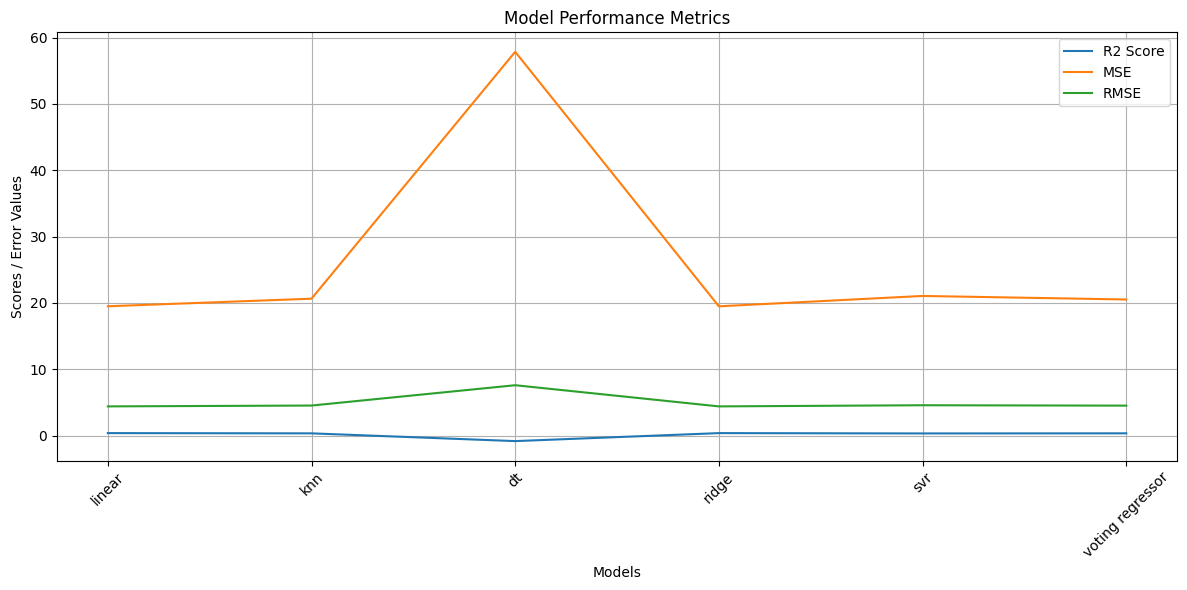

In [19]:
# line plot for performance matrics #
plt.figure(figsize=(12, 6))

# R2 Score #
plt.plot(results_df.index, results_df['R2 Score'], label='R2 Score')

# MSE #
plt.plot(results_df.index, results_df['MSE'], label='MSE')

# RMSE #
plt.plot(results_df.index, results_df['RMSE'], label='RMSE')

# formating #
plt.title('Model Performance Metrics')
plt.xlabel('Models')
plt.ylabel('Scores / Error Values')
plt.xticks(rotation=45)

# show the plot #
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()